In [1]:
!pip install -q kaggle
from google.colab import files

# Upload your kaggle.json (Kaggle API key)
files.upload()

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d tapakah68/segmentation-full-body-mads-dataset
!unzip segmentation-full-body-mads-dataset.zip -d mads_dataset


Dataset URL: https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset
License(s): Attribution-NoDerivatives 4.0 International (CC BY-ND 4.0)
 94% 445M/475M [00:06<00:00, 69.4MB/s]
100% 475M/475M [00:06<00:00, 75.3MB/s]
Archive:  segmentation-full-body-mads-dataset.zip
  inflating: mads_dataset/df.csv     
  inflating: mads_dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages/HipHop_HipHop1_C0_00180.jpg  
  inflating: mads_dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages/HipHop_HipHop1_C0_00225.jpg  
  inflating: mads_dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages/HipHop_HipHop1_C0_00360.jpg  
  inflating: mads_dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/collages/HipHop_HipHop1_C0_00405.jpg  
  inflating: mads_dataset/segmentation_full_body_mad

In [3]:
!pip uninstall -y keras
!pip uninstall -y tensorflow
!pip install tensorflow==2.18.0
!pip install keras

Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.2 MB/s eta 0:00:00


In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt


In [2]:
# Load df.csv
df = pd.read_csv('mads_dataset/df.csv')

# Base folder where 'images' and 'masks' directories exist
base_path = 'mads_dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'

# Join full paths
image_paths = [os.path.join(base_path, path) for path in df['images']]
mask_paths = [os.path.join(base_path, path) for path in df['masks']]

# Filter only existing paths
valid_image_paths, valid_mask_paths = [], []
for img, mask in zip(image_paths, mask_paths):
    if os.path.exists(img) and os.path.exists(mask):
        valid_image_paths.append(img)
        valid_mask_paths.append(mask)
    else:
        print(f"[SKIPPED] {img} or {mask} missing")


In [3]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, image_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.indices)

    def __getitem__(self, index):
        idxs = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_masks = [], []

        for i in idxs:
            img = cv2.imread(self.image_paths[i])
            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                continue

            img = cv2.resize(img, self.image_size) / 255.0
            mask = cv2.resize(mask, self.image_size)
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            batch_images.append(img)
            batch_masks.append(mask)

        if len(batch_images) == 0:
            return self.__getitem__((index + 1) % self.__len__())

        return np.array(batch_images), np.array(batch_masks)


In [6]:
def build_light_unet(input_shape=(256, 256, 3)):
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = layers.Input(shape=input_shape)

    f1, p1 = encoder_block(inputs, 32)
    f2, p2 = encoder_block(p1, 64)
    f3, p3 = encoder_block(p2, 128)
    f4, p4 = encoder_block(p3, 256)

    b = layers.Conv2D(256, 3, activation='relu', padding='same')(p4)

    d1 = decoder_block(b, f4, 256)
    d2 = decoder_block(d1, f3, 128)
    d3 = decoder_block(d2, f2, 64)
    d4 = decoder_block(d3, f1, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    return models.Model(inputs, outputs)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_unet_mads.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Build and compile model
model = build_light_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,  # Safe max with early stopping
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9215 - loss: 0.2779 
Epoch 1: val_loss improved from inf to 0.05057, saving model to best_unet_mads.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2114s 16s/step - accuracy: 0.9218 - loss: 0.2770 - val_accuracy: 0.9822 - val_loss: 0.0506
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9859 - loss: 0.0357 
Epoch 2: val_loss improved from 0.05057 to 0.01976, saving model to best_unet_mads.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2112s 16s/step - accuracy: 0.9859 - loss: 0.0356 - val_accuracy: 0.9923 - val_loss: 0.0198
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9927 - loss: 0.0184 
Epoch 3: val_loss improved from 0.01976 to 0.01375, saving model to best_unet_mads.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 2071s 15s/step - accuracy: 0.9927 - loss: 0.0183 - val_accuracy: 0.9944 - val_loss: 0.0137
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9946 - loss: 0.0134 
Epoch 4: val_loss did not improve from 0.01375
134/134 ━━━━━━━━━━━━━━━━━━━━ 2115s 15s/step - accuracy: 0.9946 - loss: 0.0134 - val_accuracy: 0.9945 - val_loss: 0.0138
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9956 - loss: 0.0108 
Epoch 5: val_loss did not improve from 0.01375
134/134 ━━━━━━━━━━━━━━━━━━━━ 2063s 15s/step - accuracy: 0.9956 - loss: 0.0109 - val_accuracy: 0.9662 - val_loss: 0.0737
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9770 - loss: 0.0602 
Epoch 6: val_loss did not improve from 0.01375
134/134 ━━━━━━━━━━━━━━━━━━━━ 2056s 15s/step - accuracy: 0.9771 - loss: 0.0600 - val_accuracy: 0.9939 - val_loss: 0.0153
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


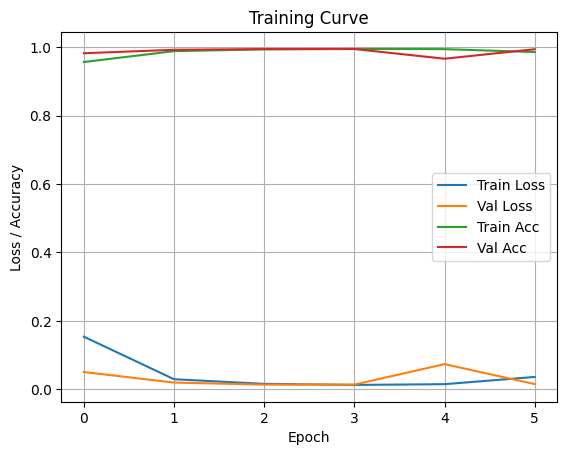

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.grid(True)
plt.show()


In [9]:
# Load legacy model
model = tf.keras.models.load_model("best_unet_mads.h5")

# Save in Keras 3 format (file or directory)
model.save("best_unet_mads.keras")  # Recommended
# or:
# model.save("best_unet_mads")  # as folder

Saving photo-1570158268183-d296b2892211.jpeg to photo-1570158268183-d296b2892211.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


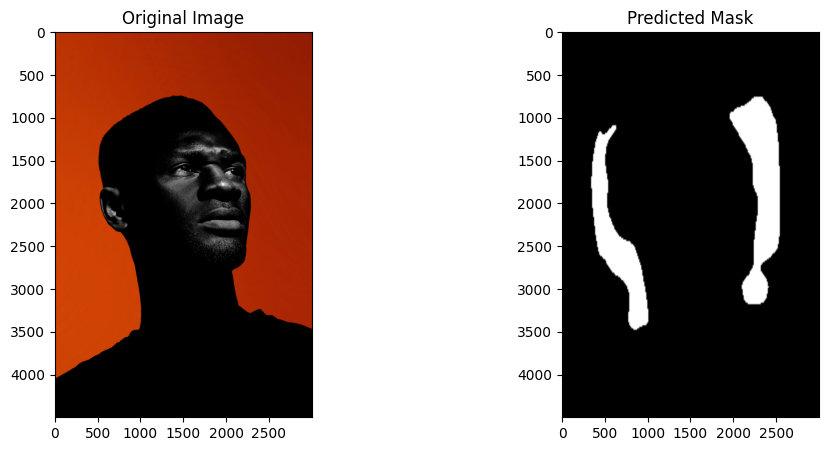

In [17]:
from google.colab import files
from PIL import Image
import io

# Upload any image file (JPG, PNG)
uploaded = files.upload()

# Get the filename
file_name = next(iter(uploaded))

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = Image.open(file_name).convert("RGB")
img_np = np.array(img)

# Resize for model
img_resized = cv2.resize(img_np, (256, 256)) / 255.0
input_tensor = np.expand_dims(img_resized, axis=0)

# Predict
pred = model.predict(input_tensor)[0]
pred_mask = (pred.squeeze() > 0.5).astype(np.uint8) * 255

# Resize mask to original image size
pred_mask_resized = cv2.resize(pred_mask, (img_np.shape[1], img_np.shape[0]))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_resized, cmap="gray")
plt.title("Predicted Mask")

plt.show()

